## 분기고시가

In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress=True, precision=4)
# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format
# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns",None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14
# 난수 시드
random_seed = 123
pd.set_option('display.max_rows', 500)

In [66]:
df = pd.read_csv('steel.csv', sep=',')
df = df.dropna()

df_all.head()

In [67]:
display(df.tail())

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock
240,2017-02-03,620,264.0000,244.0000,253.0000,253.7000,279.0000,245.0000,1007.0000
241,2017-01-27,620,270.0000,255.0000,255.0000,253.4000,279.0000,250.0000,1019.0000
242,2017-01-20,620,270.0000,251.0000,256.0000,253.4000,279.0000,270.0000,944.0000
243,2017-01-13,620,280.0000,251.0000,257.0000,253.4000,279.0000,280.0000,846.0000
244,2017-01-06,620,295.0000,253.0000,254.0000,253.4000,283.0000,280.0000,869.0000


In [68]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['quarter'] = df['date'].dt.year+ (df.date.dt.quarter)*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,quarter
0,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,475.0000,455.0000,955.0000,2021.4000
1,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,2021.3000
2,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,2021.3000
3,2021-09-10,930,537.0000,453.0000,445.0000,586.0000,475.0000,450.0000,870.0000,2021.3000
4,2021-09-03,930,545.0000,443.0000,449.0000,574.0000,475.0000,455.0000,788.0000,2021.3000


In [69]:
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]

for m in mr:
    print(m)

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]


In [70]:
df['scrap'] = df['weightA']*0.7 + df['importPriceJP']*0.2 + df['importPriceUSA']*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,quarter,scrap
0,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,475.0000,455.0000,955.0000,2021.4000,508.1000
1,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,2021.3000,507.4000
2,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,2021.3000,513.0000
3,2021-09-10,930,537.0000,453.0000,445.0000,586.0000,475.0000,450.0000,870.0000,2021.3000,513.4000
4,2021-09-03,930,545.0000,443.0000,449.0000,574.0000,475.0000,455.0000,788.0000,2021.3000,520.0000


In [49]:
df_a = df.groupby(['quarter'])['분기고시가'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()
df_b.head()

,quarter,scrap
0,2017.1000,271.5769
1,2017.2000,256.0583
2,2017.3000,293.2846
3,2017.4000,326.9667
4,2018.1000,347.8077


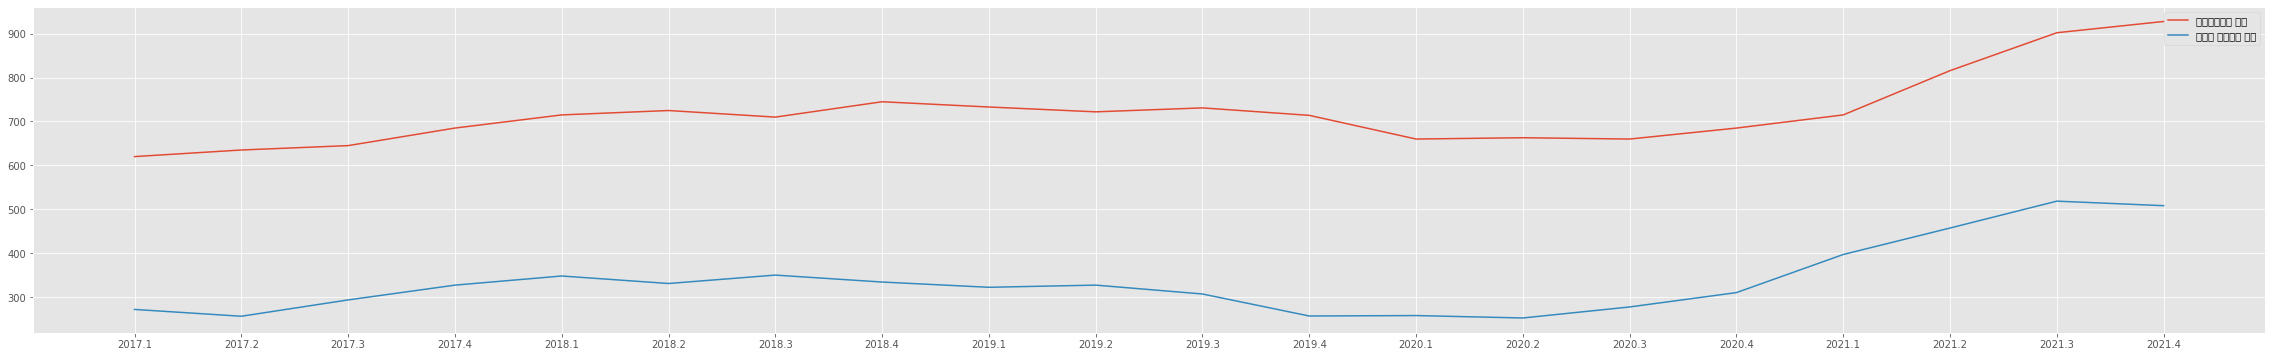

In [50]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df_a)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df_a.index, df_a['분기고시가'], label = '분기별고시가 평균')
ay.plot(df_b.index, df_b['scrap'] , label = '분기별 스크랩가 평균')
plt.xticks(xi, df_a['quarter'])
plt.legend() 

plt.show()


In [51]:
df_a[df_a.quarter==2017.1]

,quarter,분기고시가
0,2017.1000,620.0000


In [52]:
print("%d"%df_b[df_b.quarter == (2017+4*0.1)]['scrap']) 

326


In [53]:
2017+(4*0.1)

2017.4

In [54]:
import numpy as np
rng = pd.DataFrame({'date': pd.date_range('1/1/2017', periods=72, freq='M'), 'value': np.arange(72)})
print(rng)
df_a = rng.groupby([rng.date.dt.quarter, rng.date.dt.year]).mean()
df_a.index.names = ['quarter', 'year']
df_a.columns = ['mean']
print (df_a)

         date  value
0  2017-01-31      0
1  2017-02-28      1
2  2017-03-31      2
3  2017-04-30      3
4  2017-05-31      4
5  2017-06-30      5
6  2017-07-31      6
7  2017-08-31      7
8  2017-09-30      8
9  2017-10-31      9
10 2017-11-30     10
11 2017-12-31     11
12 2018-01-31     12
13 2018-02-28     13
14 2018-03-31     14
15 2018-04-30     15
16 2018-05-31     16
17 2018-06-30     17
18 2018-07-31     18
19 2018-08-31     19
20 2018-09-30     20
21 2018-10-31     21
22 2018-11-30     22
23 2018-12-31     23
24 2019-01-31     24
25 2019-02-28     25
26 2019-03-31     26
27 2019-04-30     27
28 2019-05-31     28
29 2019-06-30     29
30 2019-07-31     30
31 2019-08-31     31
32 2019-09-30     32
33 2019-10-31     33
34 2019-11-30     34
35 2019-12-31     35
36 2020-01-31     36
37 2020-02-29     37
38 2020-03-31     38
39 2020-04-30     39
40 2020-05-31     40
41 2020-06-30     41
42 2020-07-31     42
43 2020-08-31     43
44 2020-09-30     44
45 2020-10-31     45
46 2020-11-30

In [55]:
#분기별 스크랩 평균가 
#df['scrap_mean_quarter']
# 

#for line in df.iterrows():
# print(line)


for d in df['date']:
    print(d.month)
    print(d.year)
    df_year = df[df['date'].dt.year == d.year]
    df_month = df_year[df['date'].dt.month == d]



10
2021
9
2021
9
2021
9
2021
9
2021
8
2021
8
2021
8
2021
8
2021
7
2021
7
2021
7
2021
7
2021
7
2021
6
2021
6
2021
6
2021
6
2021
5
2021
5
2021
5
2021
5
2021
4
2021
4
2021
4
2021
4
2021
4
2021
3
2021
3
2021
3
2021
3
2021
2
2021
2
2021
2
2021
2
2021
1
2021
1
2021
1
2021
1
2021
1
2021
12
2020
12
2020
12
2020
12
2020
11
2020
11
2020
11
2020
11
2020
10
2020
10
2020
10
2020
10
2020
10
2020
9
2020
9
2020
9
2020
9
2020
8
2020
8
2020
8
2020
8
2020
7
2020
7
2020
7
2020
7
2020
7
2020
6
2020
6
2020
6
2020
6
2020
5
2020
5
2020
5
2020
5
2020
5
2020
4
2020
4
2020
4
2020
4
2020
3
2020
3
2020
3
2020
3
2020
2
2020
2
2020
2
2020
2
2020
1
2020
1
2020
1
2020
1
2020
1
2020
12
2019
12
2019
12
2019
12
2019
11
2019
11
2019
11
2019
11
2019
11
2019
10
2019
10
2019
10
2019
10
2019
9
2019
9
2019
9
2019
9
2019
8
2019
8
2019
8
2019
8
2019
8
2019
7
2019
7
2019
7
2019
7
2019
6
2019
6
2019
6
2019
6
2019
5
2019
5
2019
5
2019
5
2019
5
2019
4
2019
4
2019
4
2019
4
2019
3
2019
3
2019
3
2019
3
2019
3
2019
2
2019
2
2019
2
2019


In [56]:
df_year = df[df['date'].dt.year == 2021]
df_month = df_year[df['date'].dt.month == 3]
df_month

def get_quater_scrap_mean(cy, cm): #current year, #c month
    res = 0 
    if cm == 1:
        
        return res
    elif cm == 4:
        return res
    elif cm == 7:
        mr[0]
        mr[1]
        return res
    elif cm == 10:
        return res



In [57]:
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4
print(get_quarter(3))

1


In [58]:
def get_quarter_official_price(row, is_current_q):
    try:
        quarter = row.quarter
        if not is_current_q:
            quarter = quarter-1
        return df[df.quarter==row.quarter][-1:]['분기고시가'].values[0]
    except IndexError:
        return 0 #row['분기고시가']
get_quarter_official_price(df.iloc[1], True)

862

In [59]:
df.iloc[1]['분기고시가']

930

In [64]:
def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month-2 ].scrap.mean()
        scrap_mean = (mean1+mean2)/2
        print(scrap_mean)
        a = df[df.quarter==2021.3000][-1:]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[ df_b.quarter==(year + q1 * 0.1) ]['scrap']
        print(scrap_mean - previous_q1_mean_scrap)
        return scrap_mean #  get_quarter_official_price(row, True) - previous_q1_mean_scrap
    elif month % 3 == 1 : # 1 4 7 10
        q1 = get_quarter(month) -1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month,
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year,month, q1, q2))
            a= previous_q1_mean_scrap.values[0]
            b= previous_q2_mean_scrap.values[0]
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap)> 0 :
                return ( a-b )#get_quarter_official_price(row, True)
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean() 
        q1 = get_quarter(month)-1
        if q1==0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        #print("month %d "%month)
        if len( previous_q1_mean_scrap.values) > 0:
            return (mean1 - previous_q1_mean_scrap.values)[0] #get_quarter_official_price(row, False)
        else:
            return 0
df['scrap_gap'] = df['date'].apply(get_sgap)

2021-10 ( 3 2 )
521.0474999999999
17   63.9013
Name: scrap, dtype: float64
521.0474999999999
17   63.9013
Name: scrap, dtype: float64
521.0474999999999
17   63.9013
Name: scrap, dtype: float64
521.0474999999999
17   63.9013
Name: scrap, dtype: float64
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
441.895
16   45.0681
Name: scrap, dtype: float64
441.895
16   45.0681
Name: scrap, dtype: float64
441.895
16   45.0681
Name: scrap, dtype: float64
441.895
16   45.0681
Name: scrap, dtype: float64
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
389.59124999999995
15   79.6374
Name: scrap, dtype: float64
389.59124999999995
15   79.6374
Name: scrap, dtype: float64
389.59124999999995
15   79.6374
Name: scrap, dtype: float64
389.59124999999995
15   79.6374
Name: scrap, dtype: float64
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
293.92999999999995
14   16.6838
Name: scrap, dtype: float64
293.9299999999999

In [61]:
df

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,quarter,scrap
0,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,475.0000,455.0000,955.0000,2021.4000,508.1000
1,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,2021.3000,507.4000
2,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,2021.3000,513.0000
3,2021-09-10,930,537.0000,453.0000,445.0000,586.0000,475.0000,450.0000,870.0000,2021.3000,513.4000
4,2021-09-03,930,545.0000,443.0000,449.0000,574.0000,475.0000,455.0000,788.0000,2021.3000,520.0000
5,2021-08-27,925,551.0000,442.0000,455.0000,571.0000,513.5000,450.0000,688.0000,2021.3000,527.0500
6,2021-08-20,925,546.0000,441.0000,460.0000,577.0000,513.5000,450.0000,690.0000,2021.3000,523.5500
7,2021-08-13,925,545.0000,435.0000,461.0000,586.0000,513.5000,455.0000,705.0000,2021.3000,523.8500
8,2021-08-06,925,545.0000,435.0000,467.0000,596.0000,513.5000,455.0000,756.0000,2021.3000,523.8500
9,2021-07-30,862,545.0000,440.0000,468.0000,596.0000,513.5000,470.0000,778.0000,2021.3000,526.8500


KeyError: 'scrap_gap'

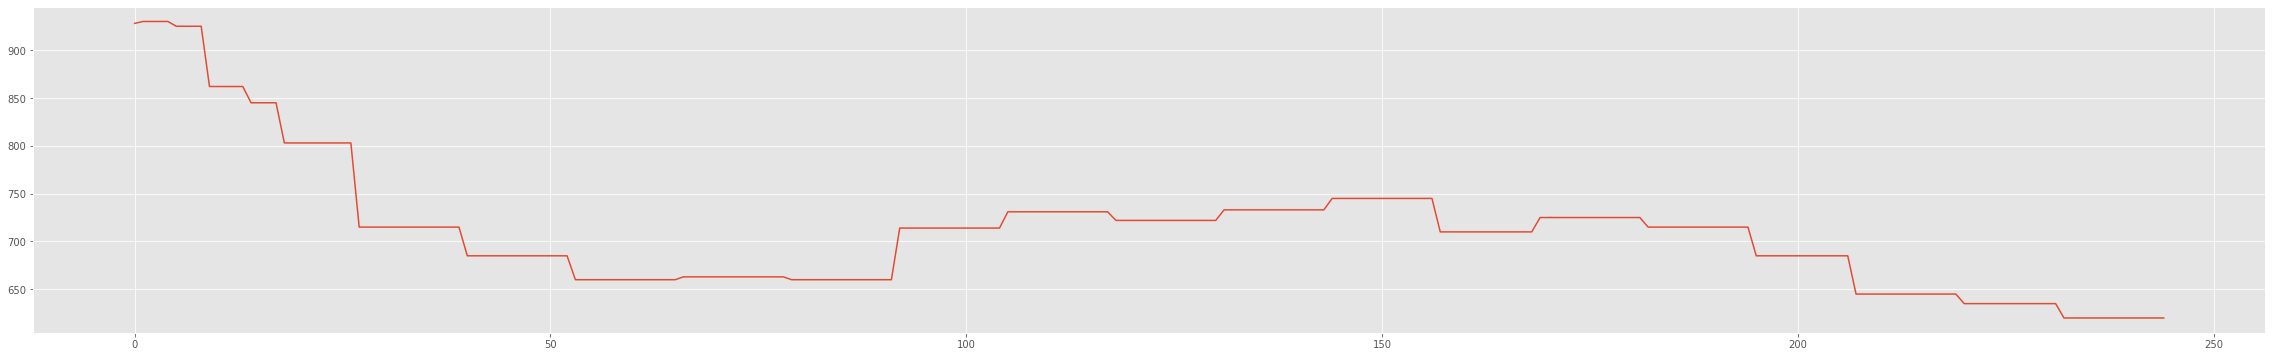

In [62]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['stock'], label = "stock제고량")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['priceUSA_TAIWAN'], label = "priceUSA_TAIWAN")
ay.plot(df.index, df['priceCN'], label = "priceCN")
ay.plot(df.index, df['priceJP'], label = "priceJP")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()